## Data understanding

In [5]:
import warnings
from datetime import datetime

import dill
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder

warnings.filterwarnings('ignore')

In [3]:
df_hits = pd.read_csv('data/ga_hits.csv')
df_sessions = pd.read_csv('data/ga_sessions.csv', low_memory=False)

In [4]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


Визаулизируем здесь частоту различных действий пользователя. Для непосредственного решения нашей задачи это не имеет значения, так как в задаче нам требуется  только бинарный таргет - совершено или нет некоторое успешное действие из списка тех действий, которые считаются таковыми. Но мы знаем, что аналитики часто в будущем могут попросить оценить совершение действий пользователем более детально - по каким-то отдельным конкретным видам или группам действий. Визуализация здесь может помочь им определиться - какие более расширенные задачи нужно будет позже поставить ML-инженерам.

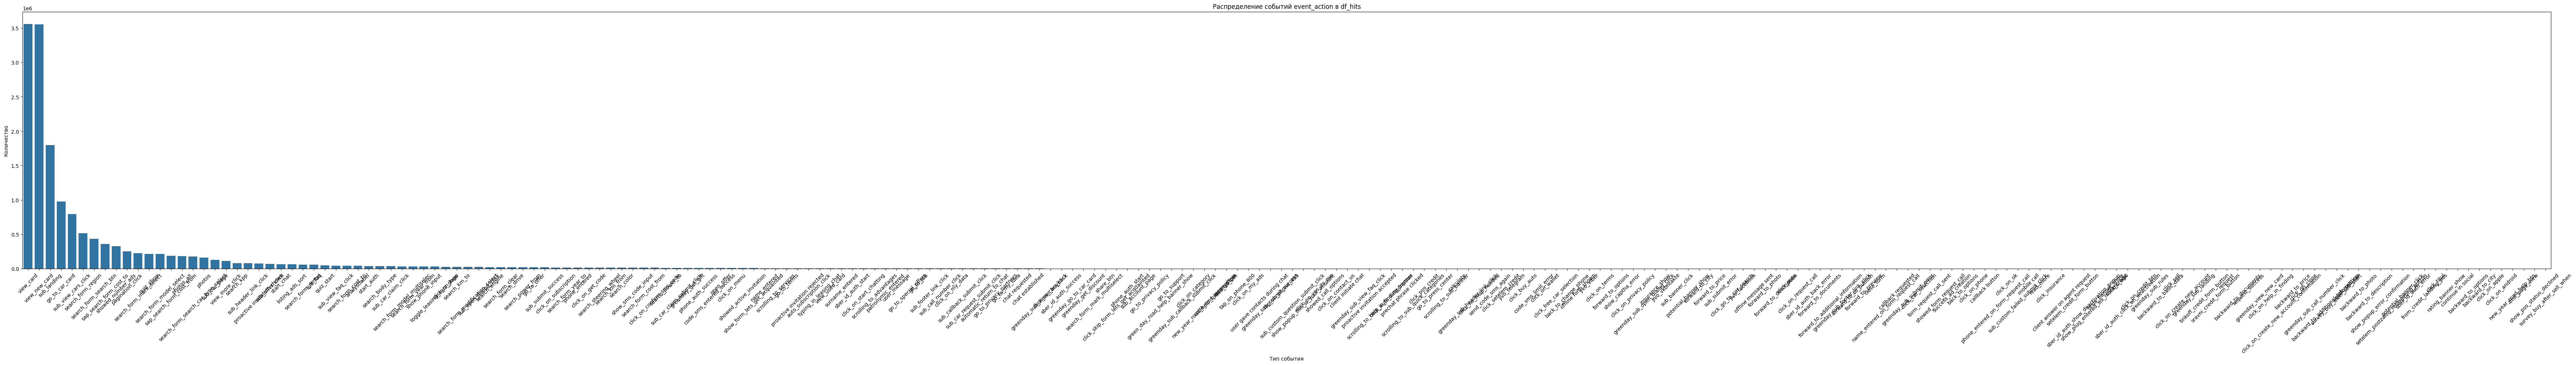

In [9]:
plt.figure(figsize=(70, 10))
sns.countplot(data=df_hits, x='event_action', 
             order=df_hits['event_action'].value_counts().index)
plt.title('Распределение событий event_action в df_hits')
plt.xticks(rotation=45)
plt.xlabel('Тип события')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

Здесь график немного мелковат, но его можно увеличить и просмотреть при необходимости. Можно, например:
- Выявить доминирующие типы событий
- Определить редкие события, которые могут быть важны для анализа
- Оценить общий паттерн поведения пользователей
Подробно делать это я не стану, при необходимости аналитики сделают это сами, график сделан для них.

In [10]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


Не будем подробно останавливаться на описании каждого атрибута из обоих датафреймов, это уже сделано в методических указаниях достаточно полно для поставленной задачи. Однако, следует отметить следующее:
1) нам необходимо построить модель для предсказания - совершит ли пользователь целевое действие, - на основании других характеристик датафреймов. Целевая переменная здесь - ga_hits.event_action. Кроме того, характеристики находятся в разных датафреймах, поэтому их следует объединить по ключу session_id
2) прежде чем преобразовывать нужные атрибуты в удобный для работы вид, отметим, что по условию задачи нам нужна зависимость целевой переменной только от атрибутов типа utm_*, device_* и geo_*, поэтому другие атрибуты экономнее будет отбросить сразу же - это сильно уменьшит ширину датафреймов и тем самым улучшит производительность при последующих трансформациях
3) и вот только после выполнения объединения датафреймов и очистки от лишних атрибутов мы будем оценивать данные и атрибуты полученного датафрейма

In [11]:
df_hits = df_hits[['session_id', 'event_action']]

In [12]:
df_sessions = df_sessions.filter(regex='^(session_id|utm_|device_|geo_)', axis=1)

Здесь мы уже отфильтровали ненужные для анализа характеристики. Можно дополнительно помочь аналитикам, предоставив им визуализацию географического распределения сессий, это часто также их очень интересует.

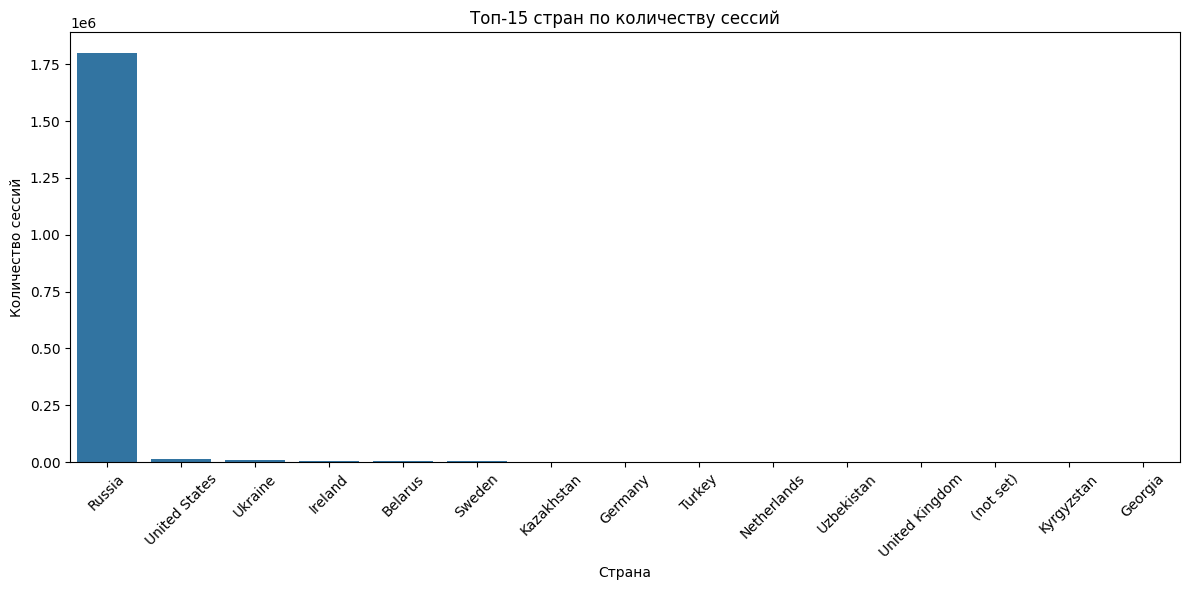

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_sessions, x='geo_country', 
             order=df_sessions['geo_country'].value_counts().index[:15])
plt.title('Топ-15 стран по количеству сессий')
plt.xticks(rotation=45)
plt.xlabel('Страна')
plt.ylabel('Количество сессий')
plt.tight_layout()
plt.show()

Это помогает аналитикам:
- Определить ключевые рынки и регионы
- Выявить аномалии в распределении по регионам
- Оценить необходимость локализации контента

In [14]:
df = pd.merge(df_hits, df_sessions, on='session_id', how='left').drop('session_id', axis=1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 14 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   event_action              object
 1   utm_source                object
 2   utm_medium                object
 3   utm_campaign              object
 4   utm_adcontent             object
 5   utm_keyword               object
 6   device_category           object
 7   device_os                 object
 8   device_brand              object
 9   device_model              object
 10  device_screen_resolution  object
 11  device_browser            object
 12  geo_country               object
 13  geo_city                  object
dtypes: object(14)
memory usage: 1.6+ GB


Итак, мы получили итоговый датафрейм, с которым мы будем работать - в нем содержаться только те характеристики, которые указаны в задании, как входные характеристики, зависимость от которых целевой переменной нужно изучить, плюс сама целевая переменная. То есть уже на этапе подготовительной работы мы частично очистили датафрейм - от ненужных полей.
Остановимся на группах полей, и оценим в целом - что они из себя представляют, и что мы предполагаем дальше с ними делать. Группа полей utm_* - это поля, описывающие различные источники трафика. Что касается группы device_* - то это описание устройств, с которых выполнялся вход на сайт, установленных на них ОС и браузерах. Группа geo_* - зависимость от страны и города также важны для аналитиков. Однако, следует выполнить очистку данных - заполнение пропусков, поиск зависимостей и удаление коррелирующих переменных.
Целевая переменная event_action содержит много вариантов значений, но все их, очевидно, можно разделить на две категории - успешный результат и неуспешный результат, то есть выполнено ли целевое действие на сайте его посетителем. Список успешных целевых значений есть в методических указаниях, мы приведем его позже, когда он понадобится. То есть целевую переменную мы будем преобразовывать из категориальной в бинарную.

Вот примерно так выглядит план работы в общих чертах. Если потребуются какие-то корректировки, мы увидим это позже в процессе работы.

Давайте дополнительно визуализируем категориалные признаки до кодирования (так как кодирование нам их сильно размножит, а также так как для анализа визуального скорее нужны человекочитаемые признаки):

In [17]:
# Определение категориальных признаков
cat_cols = df.select_dtypes(include=['object', 'category']).columns

plt.figure(figsize=(120, 6 * len(cat_cols)))
for i, col in enumerate(cat_cols):
    plt.subplot(len(cat_cols), 1, i+1)
    
    # Упорядочивание по частоте
    value_counts = df[col].value_counts()
    order = value_counts.index
    
    # Построение графика
    ax = sns.countplot(data=df, x=col, order=order)
    plt.title(f'Распределение признака: {col}', fontsize=14)
    plt.xlabel('')
    plt.ylabel('Количество', fontsize=12)
    
    # Добавление процентных меток
    total = len(df[col])
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 5,
                f'{height/total:.1%}', ha='center', fontsize=10)
    
plt.tight_layout()
plt.show()


Я использовал здесь стобчатые диаграммы. Это позволяет следующее:
- Показывает абсолютную частоту каждой категории
- Упорядочивание по убыванию частоты улучшает читаемость
- Процентные метки дают представление о доле каждой категории
- Выявляет доминирующие категории и редкие значения
- Помогает обнаружить проблемы данных (некорректные категории, дисбаланс)

Также здесь мы видим:
1) распределение значений признаков в основном мультимодальное, то есть в каждой категории, как правило, есть несколько доминирующих признаков, но некоторые категории можно считать скошенными - то есть с явным преобладание отдельной категории
2) изображение графиков у меня сильно сжатое, но при необходимости можно их увеличить или даже отсечь значения признаков со слишком малой частотой. Это связано с тем, что значений каждого признака, как правило, слишком много, поэтому pycharm мне очень сильно сжимает изображения графиков

Давайте для примера отфильтруем графики так, чтобы они показывали только значения признаков с относительной частотой больше 5%

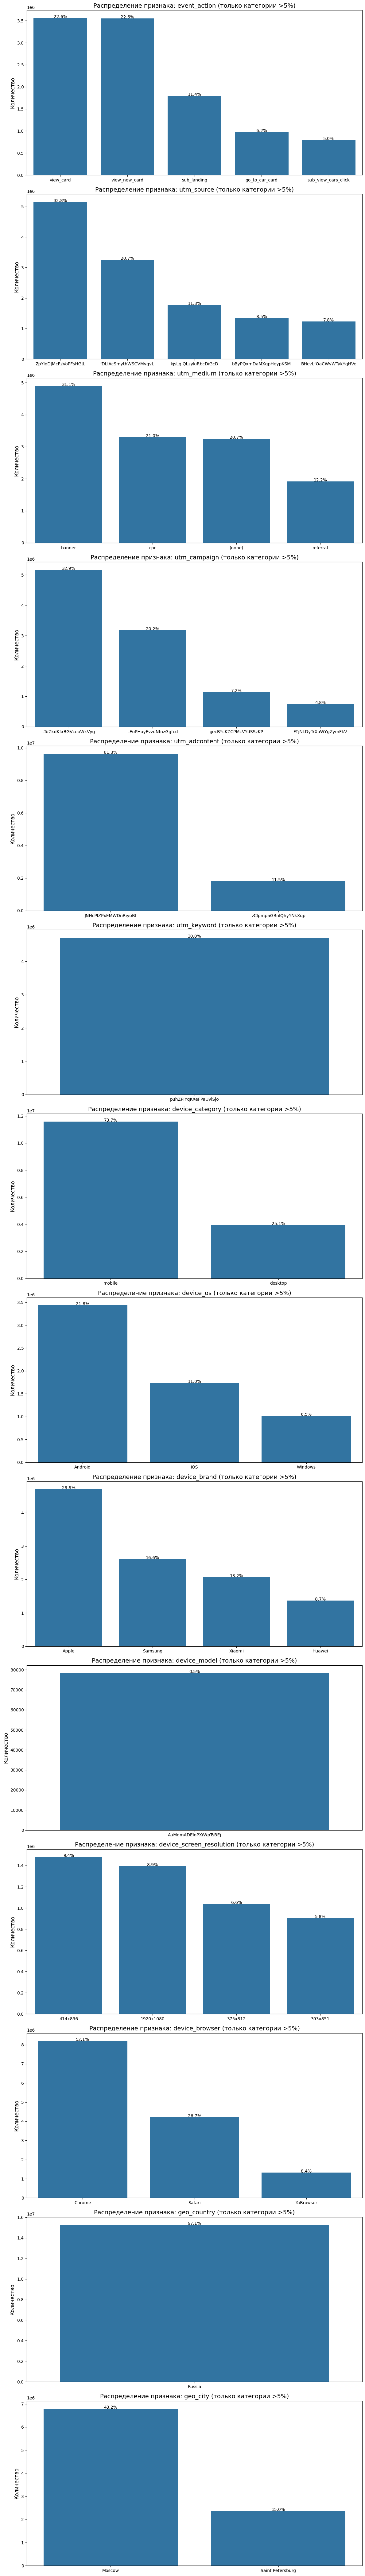

In [18]:
# Определение категориальных признаков
cat_cols = df.select_dtypes(include=['object', 'category']).columns

plt.figure(figsize=(12, 6 * len(cat_cols)))
for i, col in enumerate(cat_cols):
    plt.subplot(len(cat_cols), 1, i+1)
    
    # Рассчитываем относительные частоты
    value_counts = df[col].value_counts(normalize=True)
    
    # Фильтруем категории с частотой > 5%
    filtered_categories = value_counts[value_counts > 0.05].index
    
    # Если после фильтрации категорий не осталось, берем топ-1
    if len(filtered_categories) == 0:
        filtered_categories = value_counts.head(1).index
    
    # Фильтруем данные для графика
    filtered_data = df[df[col].isin(filtered_categories)]
    
    # Упорядочивание по частоте
    value_counts_filtered = filtered_data[col].value_counts()
    order = value_counts_filtered.index
    
    # Построение графика
    ax = sns.countplot(data=filtered_data, x=col, order=order)
    plt.title(f'Распределение признака: {col} (только категории >5%)', fontsize=14)
    plt.xlabel('')
    plt.ylabel('Количество', fontsize=12)
    
    # Добавление процентных меток
    total = len(df[col])
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 5,
                f'{height/total:.1%}', ha='center', fontsize=10)
    
plt.tight_layout()
plt.show()


Вот теперь графики распределения по значениям категорий более внятные и информативные. При необходимости мы можем варьировать нижний предел частоты, сделав его, например, 1%, смотря по пожеланиям аналитиков

## Data preparation

Ненужные атрибуты мы уже удалили ранее, теперь посмотрим на общее состояние датафрейма. Описательные характеристики:

In [9]:
df.describe(include='all')

event_action            utm_source utm_medium          utm_campaign  \
count      15726470              15684519   15685219              13486346   
unique          230                   280         55                   406   
top       view_card  ZpYIoDJMcFzVoPFsHGJL     banner  LTuZkdKfxRGVceoWkVyg   
freq        3558985               5151702    4898563               5166521   

               utm_adcontent           utm_keyword device_category device_os  \
count               12852801               6480392        15685219   6526837   
unique                   280                  1192               3        13   
top     JNHcPlZPxEMWDnRiyoBf  puhZPIYqKXeFPaUviSjo          mobile   Android   
freq                 9647665               4717082        11595541   3433515   

       device_brand          device_model device_screen_resolution  \
count      11739344                122287                 15685219   
unique          200                   104                     4947   
top           Apple  AuMdmADEIoPXiWpTsBEj                  414x896   
freq        4708652                 78321                  1480233   

       device_browser geo_country  geo_city  
count        15685219    15685219  15685219  
unique             55         159      2389  
top            Chrome      Russia    Moscow  
freq          8197216    15270908   6795118

Мне кажется, что не все эти характеристики вообще интересны для анализа из вполне разумных предположений. Например - вряд ли разрешение экрана или вид браузера имеет какое-то серьезное влияние на целевую переменную, их полезно будет их удалить для сокращения числа анализируемых характеристик. utm метки вполне могут быть все интересны аналитикам - это различная информация о рекламных компаниях, и нужно знать, что именно сработало на результат. Также я удалил бы город, их слишком много, достаточно страны, а корреляция между городом и страной очевидно, что будет слишком высокой, что плохо для будущей модели. Если когда-нибудь потребуется модель с оценкой влияния именно города на целевую переменную, я бы повтороил весь процесс, но уже удалил бы страну, чтобы исключить эту корреляцию, но в одной модели этих двух фич одновременно быть не должно.

In [10]:
df = df.drop(['device_screen_resolution', 'device_browser', 'geo_city'], axis=1)
df.describe(include='all')

event_action            utm_source utm_medium          utm_campaign  \
count      15726470              15684519   15685219              13486346   
unique          230                   280         55                   406   
top       view_card  ZpYIoDJMcFzVoPFsHGJL     banner  LTuZkdKfxRGVceoWkVyg   
freq        3558985               5151702    4898563               5166521   

               utm_adcontent           utm_keyword device_category device_os  \
count               12852801               6480392        15685219   6526837   
unique                   280                  1192               3        13   
top     JNHcPlZPxEMWDnRiyoBf  puhZPIYqKXeFPaUviSjo          mobile   Android   
freq                 9647665               4717082        11595541   3433515   

       device_brand          device_model geo_country  
count      11739344                122287    15685219  
unique          200                   104         159  
top           Apple  AuMdmADEIoPXiWpTsBEj      Russia  
freq        4708652                 78321    15270908

в целом видно, что для многих характеристик слишком много уникальных значений, недостаточно информативно, чтобы понять, какие есть пропуски и недопустимые значение, аналогичные пропускам, и что с ними делать
попробуем взглянуть на характеристики поподробнее:

In [11]:
for col_name, data in df.items():
    print(f'Характеристика: {col_name}')
    unique_values = data.unique().size
    print(f'Количество уникальных значений: {unique_values}')

    group = data.groupby(by=data, dropna=False).count()
    print('Список значений:')
    print(group)
    print()

Характеристика: event_action
Количество уникальных значений: 230
Список значений:
event_action
add_ad_btn                      749
analystlabel                  40441
auto_subscription_click        5939
automatic_return_to_chat       2751
back_to_change_phone            181
                             ...   
user_message                   4431
view_card                   3558985
view_more_click              109971
view_new_card               3551009
view_used_card                 5304
Name: event_action, Length: 230, dtype: int64

Характеристика: utm_source
Количество уникальных значений: 281
Список значений:
utm_source
AHgbtEjTEsiUMJouiDYS     113
ANoZJgYuPrWNkAAchryx     280
ArbfvYgWhqxkzywKqpQf     106
AuJjYKxJakEqFnCmyFtz      22
BAZCuyHZnaPrMGOMrcCQ       2
                        ... 
zPJpddwzkFqLMSYgtDqy       1
zhqxcsahQYAzJvRzebNp     133
zslzdtckVsyxcYqKBRRn      31
zwpKjjsMoRVCdipntaHt    1890
NaN                        0
Name: utm_source, Length: 281, dtype: int64

Характе

Обработаем отдельные столбцы различными способами, чтобы заполнить недостающие данные, либо отбросить несущественные для анализа. Те столбцы, у которых нет значений NaN или аналогичных им, пропустим и рассматривать не будем - с ними ничего не нужно делать.

In [12]:
# для utm_medium заменим значения (none) и (not set) на наиболее частое значение
df.loc[(df.utm_medium == '(none)') | (df.utm_medium == '(not set)')] = df.utm_medium.describe().top
df.utm_medium.value_counts()

utm_medium
banner               8154044
cpc                  3300503
referral             1920459
cpm                   738765
organic               646182
push                  252864
email                 241084
stories                95604
blogger_channel        87087
smartbanner            49146
tg                     33822
blogger_stories        33068
cpa                    31586
cpv                    27395
post                   21531
outlook                14702
smm                    12388
clicks                  8988
app                     3806
info_text               3401
blogger_header          2888
sms                     2051
landing                 1069
partner                  582
CPM                      412
link                     372
yandex_cpc               247
vk_smm                   211
medium                   153
static                   132
google_cpc               127
cbaafe                   110
fb_smm                    90
article                   86
nkp

In [13]:
# для device_os сделаем то же самое
df.loc[df.device_os == '(not set)'] = df.device_os.describe().top
df.device_os.value_counts()

device_os
banner           3255616
Android          3251809
iOS              1453258
Windows           819302
Macintosh         242857
Linux              27798
Chrome OS            299
BlackBerry           210
Tizen                 93
Firefox OS            37
Nokia                 12
Windows Phone          7
Samsung                1
Name: count, dtype: int64

In [14]:
# то же самое для device_brand
df.loc[df.device_brand == '(not set)'] = df.device_brand.describe().top
df.device_brand.value_counts()

device_brand
Apple        3541163
banner       3255616
Samsung      2277133
Xiaomi       1801481
Huawei       1195003
              ...   
Hafury             1
Maxvi              1
Maze               1
Microsoft          1
Honeywell          1
Name: count, Length: 196, dtype: int64

In [15]:
# то же самое для geo_country
df.loc[df.geo_country == '(not set)'] = df.geo_country.describe().top
df.geo_country.value_counts()

geo_country
Russia                      12026698
banner                       3255616
Apple                         120003
Ukraine                        57279
United States                  25511
                              ...   
Guinea                             1
Laos                               1
Central African Republic           1
Paraguay                           1
Puerto Rico                        1
Name: count, Length: 157, dtype: int64

In [16]:
# в итоге получим
df.describe(include='all')

event_action            utm_source utm_medium utm_campaign  \
count      15726470              15684758   15685219     13499298   
unique          232                   274         55          409   
top          banner  ZpYIoDJMcFzVoPFsHGJL     banner       banner   
freq        3255616               5077844    8083790      3255616   

               utm_adcontent           utm_keyword device_category device_os  \
count               12868920               9055960        15685219   9101822   
unique                   283                  1194               6        14   
top     JNHcPlZPxEMWDnRiyoBf  puhZPIYqKXeFPaUviSjo          mobile    banner   
freq                 6327294               3922987         9310341   3255616   

       device_brand device_model geo_country  
count      12804175      3425044    15685219  
unique          197          104         157  
top           Apple       banner      Russia  
freq        3539363      3255616    12026698

Оценим также данные на предмет полноты и наличия дубликатов

In [17]:
print(df.index.size)
num_duplicates = df.duplicated().sum()
print(num_duplicates)

15726470
15436197


Полных дубликатов достаточно много, будем удалять

In [18]:
df = df.drop_duplicates()
print(df.index.size)

290273


Попробуем оценить, нет ли у нас в характеристиках корреляций, что указывало бы нам, что некоторые из них можно было бы и нужно удалить.

In [19]:
key_features = df.columns.drop('event_action')
df_key_features = df[key_features]

Также выведем, какие ключевые фичи нам нужны для моделирования до трансформаций. На данном этапе это нам как будто бы и не нужно явно, но их список пригодится нам уже на этапе подготовки сервиса для составления класса Form, отвечающего за формат входных данных в сервисе. Причем, на вход сервиса фичи должны приходит в исходном удобном для человека виде, а не такими, какими они будут после кодирования.

In [31]:
df.columns

Index(['event_action', 'utm_source', 'utm_medium', 'utm_campaign',
       'utm_adcontent', 'utm_keyword', 'device_category', 'device_os',
       'device_brand', 'device_model', 'geo_country'],
      dtype='object')

In [21]:
# Подготовим матрицу корреляци
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(df_key_features)
ohe_transformed = ohe.transform(df_key_features)
df_key_features[ohe.get_feature_names_out()] = ohe_transformed
df_key_features.drop(key_features, axis=1, inplace=True)
# чтобы вся эта ячейка работала нормально, нужно не забыть увеличить в настройках pycharm выделяемую память, я поставил у себя Xmx=24g, в противном случае подсчет может упасть при нехватке ОП
corr = df_key_features.corr()

Теперь оценим, сколько у нас получилось ключевых фич уже после их кодирования

In [22]:
print(df_key_features.columns.size)

2703


Характеристик слишком много, чтобы их можно было нормально визуализировать - таблица корреляций просто не поместится на странице. Следовательно, необходимо проверить их на возможные корреляции аналитическим способом.

In [23]:
threshold = 0.6  # мой порог корреляции, обычный, но если нужно, можно сделать и больше
corr_pairs = []

# Получаем имена столбцов
columns = corr.columns

# Перебираем только верхний треугольник матрицы (без диагонали)
for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        corr_value = corr.iloc[i, j]
        if abs(corr_value) > threshold:
            corr_pairs.append((columns[i], columns[j], round(corr_value, 3)))

# Сортируем по модулю корреляции (по убыванию)
corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)

# Выводим результат
for i, pair in enumerate(corr_pairs_sorted):
    print(f"{i}: {pair[0]} vs {pair[1]}: {pair[2]}")

0: utm_source_Apple vs utm_medium_Apple: 1.0
1: utm_source_Apple vs utm_campaign_Apple: 1.0
2: utm_source_Apple vs utm_adcontent_Apple: 1.0
3: utm_source_Apple vs utm_keyword_Apple: 1.0
4: utm_source_Apple vs device_category_Apple: 1.0
5: utm_source_Apple vs device_os_Apple: 1.0
6: utm_source_Apple vs device_model_Apple: 1.0
7: utm_source_Apple vs geo_country_Apple: 1.0
8: utm_source_AuJjYKxJakEqFnCmyFtz vs utm_medium_main_polka: 1.0
9: utm_source_DnxUhHWInKVDAWzwROOC vs utm_campaign_niQdLVcBlNylrEuNcCYH: 1.0
10: utm_source_FArFiZMprRBKpQtJYEPL vs utm_adcontent_iFkBdFFnWCaZkKWtuXJi: 1.0
11: utm_source_LIWKeifdTCbuNeniIUqm vs utm_medium_link: 1.0
12: utm_source_LigOnUObPodLDexszDtn vs utm_medium_qr: 1.0
13: utm_source_LigOnUObPodLDexszDtn vs utm_campaign_RkpOyeEPgcMBSDuHLQcj: 1.0
14: utm_source_Russia vs utm_medium_Russia: 1.0
15: utm_source_Russia vs utm_campaign_Russia: 1.0
16: utm_source_Russia vs utm_adcontent_Russia: 1.0
17: utm_source_Russia vs utm_keyword_Russia: 1.0
18: utm_sour

Удалим коррелирующие колонки из df_key_features. Удалять будем по первому значению из пар - pair[0]

In [25]:
corr_columns_for_delete = [pair[0] for pair in corr_pairs_sorted]
df_key_features.drop(corr_columns_for_delete, axis=1, inplace=True)
print(df_key_features.columns.size)

2539


Теперь у нас есть все данные для обучения и оценки модели. Отдельно хочу отметить, что все ключевые характеристики - категориальные, числовые не используются по условию задачи, поэтому я не проводил оценку и очистку данных от выбросов, это не требуется в данном случае.

## Modeling

Подготовим входные данные для моделирования, очевидно, что X в данном случае - это df_key_features, а y следует вывести, как бинарную характеристику из df['event_action'], для чего возьмем из методических указаний список тех значений event_action, которые соответствуют совершению целевого действия

In [26]:
target_event_actions = ['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click']

df['event_action'] = df['event_action'].apply(lambda x: 1 if x in target_event_actions else 0)

X = df_key_features
y = df['event_action']

Теперь обучим три вида моделей с некотороми заданными параметрам и оценим качество моделей, чтобы выбрать 1) лучшую модель из трех и 2) подбором параметров добьемся, чтобы целевое действие предсказывалось с ориентировочным значением roc-auc 0.65 или лучше. Чтобы получить нужные значения, возможно, придется повторить оценку моделей несколько раз, варьируя их параметры

In [27]:
models = (
    LogisticRegression(solver='liblinear'),
    RandomForestClassifier(),
    MLPClassifier(activation='logistic', hidden_layer_sizes=(256, 128, 64))
)

best_roc_auc = .0
best_model = None
# это нужно, так как иногда cross_val_score делает разбиение так, что в таргете оказывается только единственное значение 0 или 1, как было и у меня, такая настройка помогает избежать этой ситуации
strat_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
for m in models:
    roc_auc = cross_val_score(m, X, y, cv=strat_kfold, scoring='roc_auc')
    print(f'model: {type(m).__name__}, roc_auc_mean: {roc_auc.mean():.4f}, roc_auc_std: {roc_auc.std():.4f}')
    if roc_auc.mean() > best_roc_auc:
        best_roc_auc = roc_auc.mean()
        best_model = m
        
print(f'best model: {type(m).__name__}, roc_auc: {best_roc_auc:.4f}')

model: LogisticRegression, roc_auc_mean: 0.6912, roc_auc_std: 0.0043
model: RandomForestClassifier, roc_auc_mean: 0.7159, roc_auc_std: 0.0060
model: MLPClassifier, roc_auc_mean: 0.7318, roc_auc_std: 0.0043
best model: MLPClassifier, roc_auc: 0.7318


Выполним обучение модели и сохраним ее в формате .pkl для дальнейшего развертывания в сервисе

In [28]:
best_model.fit(X, y)
with open('data/sber_auto_subscribing.pkl', 'wb') as file:
    dill.dump({
        'model': best_model,
        'metadata': {
            'name': 'Sber auto subscribing prediction model',
            'author': 'Andrei Iamangulov',
            'version': 1,
            'date': datetime.now(),
            'type': type(m).__name__,
            'accuracy': best_roc_auc
        }
    }, file)

У нас есть .pkl файл для создания сервиса, подготовленный сервис находится в файле main.py. Отдельно хочу заметить, что по условию задания не требовалось явным образом переносить шаги из jupiter ноутбука в sklearn пайплайн. Аппаратных ресурсов у меня хватило для подготовки файла .pkl для деплоймента прямо в ноутбуке. При больших требованиях к ресурсам мне бы потребовалось действительно перенести все стадии подготовки в пайплайн, выполнить его где-нибудь в облаке или на on-premise кластере (например, с установленным Spark, с соответствующей доработкой пайплайна под API Spark вместо pandas). 